In [14]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import random
import scipy
import numpy as np
import pywt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew
from skimage.feature import local_binary_pattern

c:\Users\LENOVO\Downloads\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def load_images_from_folder(folder,randomise=True,lim=-1):
    images = []
    imgData = {'fname': [], 'type': []}

    classFolders = [
        os.path.join(folder, 'akiec'),
        os.path.join(folder, 'bcc'),
        os.path.join(folder, 'bkl'),
        os.path.join(folder, 'df'),
        os.path.join(folder, 'mel'),
        os.path.join(folder, 'nv'),
        os.path.join(folder, 'vasc')
    ]

    imgSet = []

    if lim == -1:
        # Load all images without resampling
        for classFolder in classFolders:
            classFiles = os.listdir(classFolder)
            imgSet.extend([os.path.join(classFolder, f) for f in classFiles])
    else:
        # Calculate the number of images needed from each class folder
        imagesPerClass = lim // len(classFolders)

        for classFolder in classFolders:
            classFiles = os.listdir(classFolder)
            if len(classFiles) < imagesPerClass:
                # Resampling for balancing classes

                # oversamplingCount = imagesPerClass - len(classFiles)
                # print("Oversampling Count = ", oversamplingCount)

                oversampledFiles = random.choices(classFiles, k=imagesPerClass)
                imgSet.extend([os.path.join(classFolder, f) for f in oversampledFiles])
            else:
                imgSet.extend([os.path.join(classFolder, f) for f in random.sample(classFiles, imagesPerClass)])

    if randomise:
        random.shuffle(imgSet)  # Shuffle the dataset if randomise is True

    for filename in imgSet:
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
            imgData['fname'].append(filename)
            imgData['type'].append(os.path.basename(os.path.dirname(filename)))

    imgData = pd.DataFrame(imgData)

    return images, imgData

def processing(img):
    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    # Kernel for the morphological filtering
    ksize = 17 # higher kernel_size => more detail
    kernel = cv.getStructuringElement(1,(ksize,ksize))

    # BlackHat filtering
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, kernel)

    # intensify the hair countours in preparation for the inpainting algorithm
    thresholdVal = 20
    ret,thresh2 = cv.threshold(blackhat,thresholdVal,255,cv.THRESH_BINARY)

    res = cv.inpaint(img,thresh2,1,cv.INPAINT_TELEA)

    medFiltered = cv.medianBlur(res,ksize=11)

    # Convert the image to LAB {Luminance, A Color Channel, B Color Channel} color space
    lab_image = cv.cvtColor(medFiltered, cv.COLOR_RGB2LAB)
    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv.split(lab_image)

    clahe = cv.createCLAHE(clipLimit=1.25, tileGridSize=(8, 8))
    l_channel_clahe = clahe.apply(l_channel)

    # Merge the enhanced L channel with the original A and B channels
    enhanced_lab_image = cv.merge((l_channel_clahe, a_channel, b_channel))

    # Convert the enhanced LAB image back to BGR
    enhancedImage = cv.cvtColor(enhanced_lab_image, cv.COLOR_LAB2RGB)

    return enhancedImage

def imgPreProcessing(imgSet,multiple=False):
    if multiple:
        processedImgSet = []
        imgIndx = 0

    if multiple:
        for i in imgSet:
            enImg = processing(i)
            imgIndx+=1
            processedImgSet.append(enImg)
        return processedImgSet
    else:
        return processing(imgSet)


def entropyCalc(img):
    entropyFeatureVector = {}
    ## ENTROPY EXTRACTION/CALCULATION
    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    #histogram Creation
    binsCount = 128
    hist, _ = np.histogram(gray.ravel(), bins=binsCount, range=(0, binsCount))
    if hist.sum() == 0:
        entropyFeatureVector["SE"]=0.0
        entropyFeatureVector["TE"]=0
        entropyFeatureVector["NE"]=0.0
        entropyFeatureVector["E"]=0.0
        return entropyFeatureVector

    prob_dist = hist / hist.sum()
    image_entropy = scipy.stats.entropy(prob_dist, base=2)
    entropyFeatureVector["E"] = image_entropy                                   ## ENTROPY (E)

    ## SHANNON ENTROPY EXTRACTION/CALCULATION
    shEntropy = -np.sum(prob_dist * np.log2(prob_dist + np.finfo(float).eps))
    entropyFeatureVector["SE"] = shEntropy                                      ## SHANNON ENTROPY (SE)

    ## THRESHOLD ENTROPY EXTRACTION/CALCULATION
    # Initialize variables to keep track of the best threshold and maximum entropy
    best_threshold = 0
    max_entropy = 0.0
    # Iterate through possible threshold values and find the one with maximum entropy
    for threshold in range(1, 256):
        lower_prob = prob_dist[:threshold].sum()
        upper_prob = prob_dist[threshold:].sum()

        lower_entropy = -np.sum(prob_dist[:threshold] / (lower_prob + np.finfo(float).eps) * np.log2(prob_dist[:threshold] / (lower_prob + np.finfo(float).eps) + np.finfo(float).eps))
        upper_entropy = -np.sum(prob_dist[threshold:] / (upper_prob + np.finfo(float).eps) * np.log2(prob_dist[threshold:] / (upper_prob + np.finfo(float).eps) + np.finfo(float).eps))

        combined_entropy = lower_prob * lower_entropy + upper_prob * upper_entropy
        # print(combined_entropy)
        if combined_entropy > max_entropy:
            max_entropy = combined_entropy
            best_threshold = threshold
    entropyFeatureVector["TE"] = best_threshold                                 ## THRESHOLD ENTROPY (TE)

    ## NORMALISED SHANNON ENTROPY EXTRACTION/CALCULATION
    num_pixels = gray.size
    normalized_entropy = shEntropy / (np.log2(num_pixels))
    entropyFeatureVector["NE"] = normalized_entropy                             ## NORMALISED SHANNON ENTROPY (NE)
    return entropyFeatureVector

def entropyFeatureExtraction(preProcessedImgs,multiple=False):
    if multiple:
        enFeatureSet = []
        imgIndx = 0
        for i in preProcessedImgs:
            entropyFeatureVector = entropyCalc(i)
            enFeatureSet.append(entropyFeatureVector)
            imgIndx += 1
        return enFeatureSet
    else:
        entropyFeatureVector = entropyCalc(preProcessedImgs)
        return entropyFeatureVector


def textureCal(img):
    img = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    txFeatureVector = {}
    distances = [1]  # You can use multiple distances
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Four angles (0, 45, 90, and 135 degrees)
    glcm = np.zeros((256, 256), dtype=np.float64)
    for d, distance in enumerate(distances):
        for a, angle in enumerate(angles):
            dx = int(distance * np.cos(angle))
            dy = int(distance * np.sin(angle))
            for i in range(img.shape[0] - distance):
                for j in range(img.shape[1] - distance):
                    glcm[img[i, j], img[i + dx, j + dy]] += 1

    glcm /= glcm.sum()
    energy = np.sum(glcm ** 2)
    contrast = np.sum((np.arange(256).reshape(256, 1) - np.arange(256)) ** 2 * glcm)
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    homogeneity = np.sum(glcm / (1 + np.abs(np.arange(256).reshape(256, 1) - np.arange(256))))
    txFeatureVector["GLCMenergy"]=energy
    txFeatureVector["GLCMcontrast"]=contrast
    txFeatureVector["GLCMentropy"]=entropy
    txFeatureVector["GLCMhomogeneity"]=homogeneity
    return txFeatureVector

def textureFeatureExtraction(preProcessedImgs,multiple=False):
    if multiple:
        txFeatureSet = []
        imgIndx = 0
        for i in preProcessedImgs:
            txFeatureVector = textureCal(i)
            txFeatureSet.append(txFeatureVector)
            imgIndx+=1
        return txFeatureSet
    else:
        txFeatureVector = textureCal(preProcessedImgs)
        return txFeatureVector

def statFeatureCalc(img):
    statFeatureVector = {}
    ##GRAY SCALE MEAN
    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    grayMean = np.mean(gray)
    statFeatureVector["GSM"] = grayMean
    ##GRAY SCALE STD
    grayStd = np.std(gray)
    statFeatureVector["GSTD"] = grayStd
    #GRAY L1 NORM
    grayl1Norm = np.linalg.norm(gray, ord=1)
    statFeatureVector["GL1N"] = grayl1Norm
    #GRAY L2 NORM
    grayl2Norm = np.linalg.norm(gray, ord=2)
    statFeatureVector["GL2N"] = grayl2Norm
    #GRAY P2P
    grayPixelRange = np.ptp(gray)
    statFeatureVector["GRAYP2P"] = grayPixelRange

    skewValue = skew(gray.flatten())
    # print("Skewness:", skewness_value)
    statFeatureVector["GSKEW"]=skewValue

    ##GRAY MEDIAN
    grayMedian = np.median(gray)
    statFeatureVector["GMEDIAN"] = grayMedian

    ##WAVELET FEATURES
    waveletFeatures = {}
    wavelet_family = 'haar'
    level = 2

    coeffs = pywt.wavedec2(gray,wavelet_family,level = level)

    wgEnergy = [np.sum(np.square(c)) for c in coeffs]
    wgSTD = [np.std(c) for c in coeffs]

    # Calculate wavelet contrast and homogeneity
    wgContrast = []
    wgHomogeneity = []

    for i in range(1, len(coeffs)):
        detail = coeffs[i]
        mean = np.mean(detail)
        contrast = np.sum(np.square(detail - mean))
        homogeneity = 1 / (1 + contrast)
        wgContrast.append(contrast)
        wgHomogeneity.append(homogeneity)

    waveletFeatures["WGENERGY"] = wgEnergy
    waveletFeatures["WGSTD"] = wgSTD
    waveletFeatures["WGCONTRAST"] = wgContrast
    waveletFeatures["WGHOMOGENEITY"] = wgHomogeneity
    statFeatureVector["WAVELET"] = waveletFeatures
    return statFeatureVector

def statsFeatureExtraction(preProcessedImgs,multiple=False):
    if multiple:
        stFeatureSet = []
        imgIndx = 0
        for i in preProcessedImgs:
            statFeatureVector = statFeatureCalc(i)
            stFeatureSet.append(statFeatureVector)
            imgIndx += 1
        return stFeatureSet
    else:
        statFeatureVector = statFeatureCalc(preProcessedImgs)
        return statFeatureVector

def lbpFeatureCalc(img):
    lbpFeatureVector = {}
    # LBP parameters
    radius = 3
    n_points = 8 * radius
    # method = 'uniform'

    gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    # Calculate LBP
    # lbp = local_binary_pattern(gray, n_points, radius, method)
    lbp = local_binary_pattern(gray, n_points, radius)

    # Calculate histogram of LBP and normalize
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram

    for itr in range(len(hist)):
        lbpFeatureVector["LBP-"+str(itr+1)] = hist[itr]
    # print("LBP Histogram:")
    # print(hist)
    
    return lbpFeatureVector


def lbpFeatureExtraction(preProcessedImgs,multiple=False):
    if multiple:
        lbpFeatureSet = []
        imgIndx = 0
        for i in preProcessedImgs:
            lbpFeatureVector = lbpFeatureCalc(i)
            lbpFeatureSet.append(lbpFeatureVector)
            imgIndx += 1
        return lbpFeatureSet
    else:
        lbpFeatureVector = lbpFeatureCalc(preProcessedImgs)
        return lbpFeatureVector



def dfRowGen(lbpFeatures,enFeatures,stFeatures,txFeatures,classifyDF=None,train=0):
    x = {}
    if train:
        x["type"] = classifyDF
    for iter in enFeatures.items():
        x[iter[0]] = iter[1]
    for iter in list(stFeatures.items())[:7]:
        x[iter[0]] = iter[1]
    for iter in list(stFeatures.items())[7][1].items():
        for q in range(len(iter[1])):
            x[iter[0]+str(q+1)] = iter[1][q]
    for iter in txFeatures.items():
        x[iter[0]] = iter[1]
    for iter in lbpFeatures.items():
        x[iter[0]] = iter[1]
    if train:
        x = pd.DataFrame.from_dict(x,orient='index').T #T for transpose
    else:
        x = np.array(list(x.items()))
    return(x)

def dfGenerator(lbpFeatures,enFeatures,stFeatures,txFeatures,classifyDF=None,train=0):
    finalDF = []
    if train:
        # training
        for o in range(len(classifyDF)):
            # print(o)
            # print(enFeatures[o])
            # print(stFeatures[o])
            # print(txFeatures[o])
            # print(classifyDF[o])
            # print(train)
            finalDF.append(dfRowGen(lbpFeatures[o],enFeatures[o],stFeatures[o],txFeatures[o],classifyDF.iloc[o]["type"],train))
        finalDF = pd.concat(finalDF, ignore_index=True)
    else:
        return (np.array(dfRowGen(lbpFeatures,enFeatures,stFeatures,txFeatures,classifyDF,train)))
    return finalDF


currFolderPath = os.getcwd()
dataSetPath = os.path.join(currFolderPath,'SkinCancer-Datasetimgs')

def training():
    imagesFolder = os.path.join(dataSetPath,'TrainingImgs')
    (imgs,classifyDF) = load_images_from_folder(imagesFolder,randomise=False,lim=3500)    # CHANGE THIS VALUE TO LOAD MORE IMAGES AND TO RANDOMISE THE INPUT
    # print(classifyDF)
    imgs = np.array(imgs)
    print("Image N-Array Shape: " ,imgs.shape)
    processedImgs = imgPreProcessing(imgs,multiple=True)

    enFeatures = entropyFeatureExtraction(processedImgs,multiple=True)
    stFeatures = statsFeatureExtraction(processedImgs,multiple=True)
    txFeatures = textureFeatureExtraction(processedImgs,multiple=True)
    lbpFeatures = lbpFeatureExtraction(processedImgs,multiple=True)
    return dfGenerator(lbpFeatures,enFeatures,stFeatures,txFeatures,classifyDF,train=1)

# print(finalRes)
# print("FinalRes DF Shape: " ,finalRes.shape)

def newImgLoad(imgPath):
    img = cv.imread(imgPath)
    processedImg = imgPreProcessing(img,multiple=False)
    enFeatures = entropyFeatureExtraction(processedImg)
    stFeatures = statsFeatureExtraction(processedImg)
    txFeatures = textureFeatureExtraction(processedImg)
    lbpFeatures = lbpFeatureExtraction(processedImg)
    featureDF = dfGenerator(lbpFeatures, enFeatures, stFeatures, txFeatures)
    return featureDF


In [2]:
finalRes = training()
finalRes.to_csv('features3500.csv',index=False)

NameError: name 'training' is not defined

In [19]:
finalRes = pd.read_csv('features3500.csv',index_col=None)
print(finalRes)

       type         E        SE  TE        NE         GSM       GSTD     GL1N  \
0     akiec  4.558389  4.558389   1  0.252646  160.841956  17.768689  77758.0   
1     akiec  5.628514  5.628514   4  0.311957  173.709141  24.325953  87317.0   
2     akiec  5.864416  5.864416   2  0.325032  189.565626  32.180342  96897.0   
3     akiec  5.832665  5.832665   1  0.323272  160.457563  34.760104  82067.0   
4     akiec  5.667929  5.667929   2  0.314141  177.530807  26.236639  89171.0   
...     ...       ...       ...  ..       ...         ...        ...      ...   
3495   vasc  6.759929  6.759929   1  0.374665  192.437481  30.113103  91771.0   
3496   vasc  6.391691  6.391691   8  0.354256  153.163789  25.087054  76953.0   
3497   vasc  5.719731  5.719731   1  0.317013  180.994204  20.349352  89005.0   
3498   vasc  6.249289  6.249289   1  0.346363  163.628670  30.888089  84326.0   
3499   vasc  5.931934  5.931934   8  0.328774  148.846130  25.543574  76724.0   

               GL2N  GRAYP2

In [5]:
# ## Visualization
# # Visualize features in relation to the target variable
# sns.boxplot(x='type', y='E', data=finalRes)
# plt.title('Feature Distribution by Class')
# plt.show()


In [20]:
## STR to INT
type_mapping = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6
}

y = finalRes['type']
y= y.replace(type_mapping)

x = finalRes.drop(columns=['type'])

In [5]:
# ## Exploratory Data Analysis (EDA)

# # Display summary statistics of the dataset
print(finalRes.describe())
# print(finalRes)
# print(x)
# print(y)

                 E            SE           TE            NE          GSM  \
count  3500.000000  3.500000e+03  3500.000000  3.500000e+03  3500.000000   
mean      5.700450  5.700450e+00     4.021429  3.159440e-01   160.578985   
std       0.843596  8.435959e-01    13.332186  4.675578e-02    16.131639   
min       0.000000 -3.203427e-16     0.000000 -1.775479e-17    71.483389   
25%       5.291137  5.291137e+00     1.000000  2.932580e-01   149.151393   
50%       5.863566  5.863566e+00     2.000000  3.249846e-01   160.933417   
75%       6.292465  6.292465e+00     4.000000  3.487560e-01   171.818569   
max       6.865837  6.865837e+00   128.000000  3.805348e-01   221.449533   

              GSTD           GL1N           GL2N      GRAYP2P        GSKEW  \
count  3500.000000    3500.000000    3500.000000  3500.000000  3500.000000   
mean     28.946799   82486.332000   84165.777273   169.150000    -1.356171   
std      10.522767    7526.295707    8188.092960    34.887269     0.859126   
min

In [6]:
x.head()

,E,SE,TE,NE,GSM,GSTD,GL1N,GL2N,GRAYP2P,GSKEW,...,LBP-17,LBP-18,LBP-19,LBP-20,LBP-21,LBP-22,LBP-23,LBP-24,LBP-25,LBP-26
0,4.558389,4.558389,1,0.252646,160.841956,17.768689,77758.0,83747.839211,111,-0.680609,...,0.013213,0.000755,0.000000,0.000378,0.000755,0.0,0.000755,0.002643,0.005285,0.000378
1,5.628514,5.628514,4,0.311957,173.709141,24.325953,87317.0,90621.508516,166,-0.930766,...,0.022682,0.000493,0.000493,0.000986,0.001479,0.0,0.001479,0.001479,0.014300,0.000000
2,5.864416,5.864416,2,0.325032,189.565626,32.180342,96897.0,99028.910383,192,-1.547577,...,0.009434,0.000449,0.000000,0.000898,0.000898,0.0,0.000000,0.002246,0.009434,0.002246
3,5.832665,5.832665,1,0.323272,160.457563,34.760104,82067.0,84228.094258,172,-0.780503,...,0.012967,0.000381,0.000000,0.000000,0.000763,0.0,0.000000,0.001526,0.015256,0.000763
4,5.667929,5.667929,2,0.314141,177.530807,26.236639,89171.0,92539.097108,161,-1.122622,...,0.010417,0.000496,0.000000,0.000992,0.000496,0.0,0.000496,0.001984,0.009425,0.000496


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64

In [8]:
x.corr()

,E,SE,TE,NE,GSM,GSTD,GL1N,GL2N,GRAYP2P,GSKEW,...,LBP-17,LBP-18,LBP-19,LBP-20,LBP-21,LBP-22,LBP-23,LBP-24,LBP-25,LBP-26
E,1.000000,1.000000,0.083470,1.000000,-0.181012,0.616651,0.079625,-0.142996,0.755778,-0.364432,...,-0.057233,0.199360,0.086988,-0.032919,-0.119790,0.101289,0.064708,-0.147065,-0.033524,0.144678
SE,1.000000,1.000000,0.083470,1.000000,-0.181012,0.616651,0.079625,-0.142996,0.755778,-0.364432,...,-0.057233,0.199360,0.086988,-0.032919,-0.119790,0.101289,0.064708,-0.147065,-0.033524,0.144678
TE,0.083470,0.083470,1.000000,0.083470,-0.066669,0.085571,-0.024109,-0.061468,0.123490,-0.022588,...,-0.010093,0.085882,0.062498,-0.035106,-0.033266,-0.031686,0.004538,0.031428,0.007082,0.106289
NE,1.000000,1.000000,0.083470,1.000000,-0.181012,0.616651,0.079625,-0.142996,0.755778,-0.364432,...,-0.057233,0.199360,0.086988,-0.032919,-0.119790,0.101289,0.064708,-0.147065,-0.033524,0.144678
GSM,-0.181012,-0.181012,-0.066669,-0.181012,1.000000,-0.168237,0.782061,0.995926,-0.011969,-0.368784,...,0.177252,-0.122130,-0.040314,0.026864,0.107001,-0.037575,-0.078067,0.066416,0.202386,-0.068493
GSTD,0.616651,0.616651,0.085571,0.616651,-0.168237,1.000000,0.381576,-0.089071,0.714110,0.157885,...,-0.184491,0.160010,0.068812,-0.092065,-0.191907,0.045102,0.072945,-0.169125,-0.073143,0.161674
GL1N,0.079625,0.079625,-0.024109,0.079625,0.782061,0.381576,1.000000,0.825710,0.329554,-0.091275,...,0.079012,-0.044365,-0.003297,-0.044284,-0.015954,-0.033414,-0.025080,-0.039196,0.145711,0.006688
GL2N,-0.142996,-0.142996,-0.061468,-0.142996,0.995926,-0.089071,0.825710,1.000000,0.035411,-0.357337,...,0.168236,-0.107147,-0.036369,0.022103,0.094081,-0.034098,-0.072436,0.054268,0.203008,-0.051251
GRAYP2P,0.755778,0.755778,0.123490,0.755778,-0.011969,0.714110,0.329554,0.035411,1.000000,-0.143985,...,-0.111177,0.145720,0.078243,-0.067373,-0.153020,0.056571,0.102753,-0.125476,-0.045883,0.096417
GSKEW,-0.364432,-0.364432,-0.022588,-0.364432,-0.368784,0.157885,-0.091275,-0.357337,-0.143985,1.000000,...,-0.204082,-0.114780,-0.027739,-0.110080,-0.068130,-0.128019,0.034760,-0.005443,-0.188160,-0.141553


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature Importances:
Feature 1: 0.017434040232029744
Feature 2: 0.020725514016278923
Feature 3: 0.0053242970622996945
Feature 4: 0.019838069814762084
Feature 5: 0.022618135948196314
Feature 6: 0.008247257743279592
Feature 7: 0.022078313635810913
Feature 8: 0.010764666595541218
Feature 9: 0.020723467498437675
Feature 10: 0.0486226689975611
Feature 11: 0.00702368725548925
Feature 12: 0.011035603202116178
Feature 13: 0.010634518969342891
Feature 14: 0.009030674379047872
Feature 15: 0.008762062906496459
Feature 16: 0.009914278199469159
Feature 17: 0.007627238080965137
Feature 18: 0.007346415772238724
Feature 19: 0.00936667493583091
Feature 20: 0.0015568011119474808
Feature 21: 0.0023642910270863108
Feature 22: 0.012520977228313381
Feature 23: 0.02150320315797845
Feature 24: 0.007278127918680318
Feature 25: 0.010384736688152226
Feature 26: 0.012260011442412583
Feature 27: 0.10785307973107162
Feature 28: 0.029473601782877074
Feature 29: 0.022422609492805598
Feature 30: 0.015805599998185045
F

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

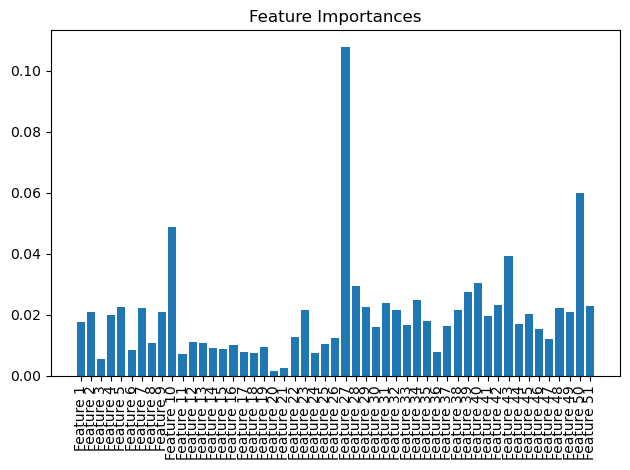

In [9]:
feature=pd.get_dummies(finalRes["type"])
data=pd.concat([x,feature],axis=1)


# print(data)
data.corr()
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["akiec"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Feature Importances:
Feature 1: 0.010459009943222169
Feature 2: 0.013189713439204538
Feature 3: 0.009312173898624437
Feature 4: 0.011348336136601718
Feature 5: 0.03171773887220495
Feature 6: 0.02878945861119802
Feature 7: 0.022919824672532424
Feature 8: 0.019230738709269
Feature 9: 0.036902179556214706
Feature 10: 0.022723457872122155
Feature 11: 0.014878525071804365
Feature 12: 0.012882922079053317
Feature 13: 0.00845665493390055
Feature 14: 0.005888842576675818
Feature 15: 0.04299214523827315
Feature 16: 0.0067764926387556355
Feature 17: 0.005166536590691263
Feature 18: 0.0059914749231560595
Feature 19: 0.006241011894883634
Feature 20: 0.0014215436445296434
Feature 21: 0.0025726395157033865
Feature 22: 0.024477716840938024
Feature 23: 0.006840751755465729
Feature 24: 0.01493897515971562
Feature 25: 0.02990174552624062
Feature 26: 0.015228142839883744
Feature 27: 0.027334529816994066
Feature 28: 0.023529788445834657
Feature 29: 0.018089778828431113
Feature 30: 0.028584576441896114
Fea

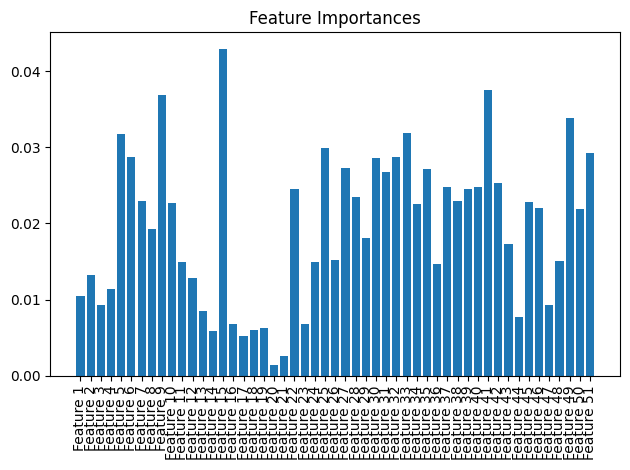

In [26]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["bcc"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Feature Importances:
Feature 1: 0.013837170814097306
Feature 2: 0.013492265430041579
Feature 3: 0.010575278542181937
Feature 4: 0.013724511093171823
Feature 5: 0.016541924225041832
Feature 6: 0.011861562467875446
Feature 7: 0.02866052718199587
Feature 8: 0.02171861731054322
Feature 9: 0.03273016860831199
Feature 10: 0.031662313752142485
Feature 11: 0.03493215634380084
Feature 12: 0.0332894029527546
Feature 13: 0.005312532247515994
Feature 14: 0.006664898744228444
Feature 15: 0.01006905437505766
Feature 16: 0.007323688171570732
Feature 17: 0.005660443688033564
Feature 18: 0.00562247973544922
Feature 19: 0.005652739814054324
Feature 20: 0.0022354114152398357
Feature 21: 0.0032754714583189595
Feature 22: 0.017123251631114927
Feature 23: 0.008313948514265066
Feature 24: 0.012428561429857257
Feature 25: 0.013686733340790626
Feature 26: 0.01943578916824892
Feature 27: 0.02327223045173449
Feature 28: 0.03460716444096767
Feature 29: 0.02725355888584596
Feature 30: 0.022931206906255556
Feature 

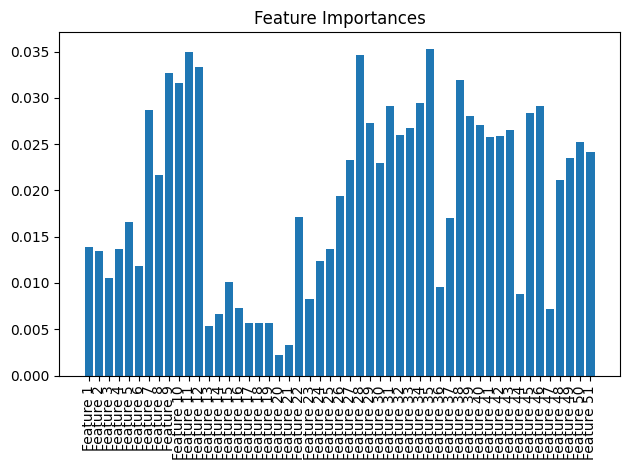

In [27]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["bkl"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Feature Importances:
Feature 1: 0.042039668454346396
Feature 2: 0.036698188692423944
Feature 3: 0.004557201472779341
Feature 4: 0.04066554556477789
Feature 5: 0.012292558962538362
Feature 6: 0.026081847117570636
Feature 7: 0.0386363207861873
Feature 8: 0.006983161728161383
Feature 9: 0.028190777886613425
Feature 10: 0.01670484300713911
Feature 11: 0.008012573448869608
Feature 12: 0.008868518891454657
Feature 13: 0.006972358034873827
Feature 14: 0.0040361067822685046
Feature 15: 0.02424711465881418
Feature 16: 0.006036188806448681
Feature 17: 0.005298158370065468
Feature 18: 0.007324319304955402
Feature 19: 0.004806297776184185
Feature 20: 0.0019053345771164755
Feature 21: 0.002187894885155922
Feature 22: 0.01821937270447922
Feature 23: 0.003212127185786399
Feature 24: 0.01170342696358048
Feature 25: 0.015490183318004204
Feature 26: 0.013076748433854968
Feature 27: 0.03946840633410119
Feature 28: 0.05298676482652862
Feature 29: 0.031356366368482706
Feature 30: 0.031643949137299295
Featu

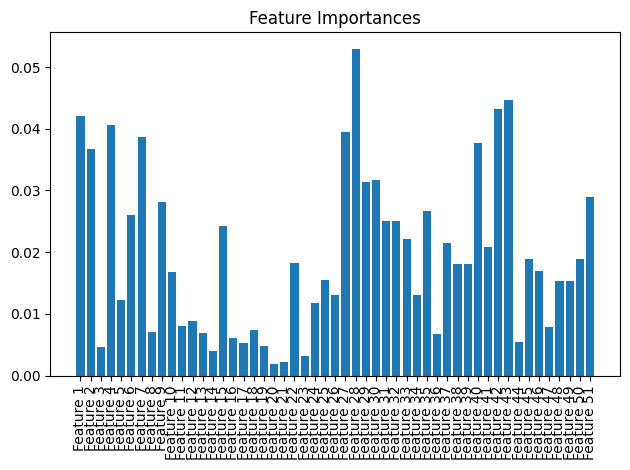

In [28]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["df"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Feature Importances:
Feature 1: 0.036526054228534895
Feature 2: 0.03694845127311389
Feature 3: 0.007718836207886366
Feature 4: 0.03436082052721655
Feature 5: 0.028230385973251115
Feature 6: 0.030387414376296315
Feature 7: 0.024528057016027775
Feature 8: 0.018966281102213038
Feature 9: 0.03323086542059718
Feature 10: 0.02831045234412817
Feature 11: 0.014002249263264358
Feature 12: 0.011867083335580637
Feature 13: 0.01124156883126653
Feature 14: 0.005068137918850632
Feature 15: 0.019587652430103852
Feature 16: 0.011546991143587423
Feature 17: 0.004967545634035218
Feature 18: 0.010575078934024913
Feature 19: 0.005218067578786428
Feature 20: 0.0011977755645936196
Feature 21: 0.002132670491767622
Feature 22: 0.016135547600757832
Feature 23: 0.009735349229317814
Feature 24: 0.030017904401045303
Feature 25: 0.014814506225981032
Feature 26: 0.015699772326549975
Feature 27: 0.023360395738337696
Feature 28: 0.024054119438768465
Feature 29: 0.019285821724763026
Feature 30: 0.025855605986006936
Fe

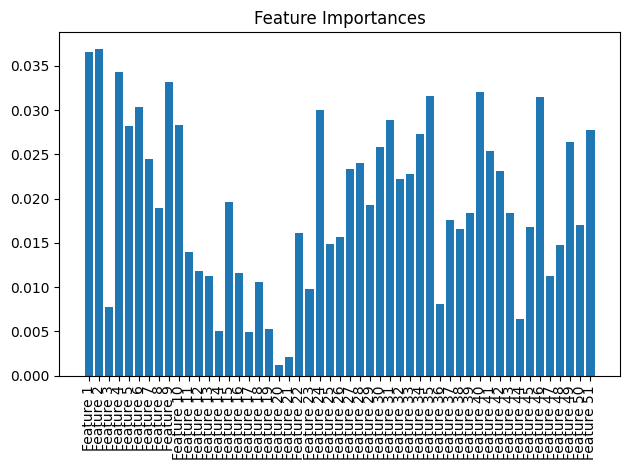

In [29]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["mel"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Feature Importances:
Feature 1: 0.0323666745548298
Feature 2: 0.028900574091820043
Feature 3: 0.006840870949675137
Feature 4: 0.030810486946300845
Feature 5: 0.019606921684770948
Feature 6: 0.023096328496387788
Feature 7: 0.018730373435954257
Feature 8: 0.012251515105672456
Feature 9: 0.051901002845999425
Feature 10: 0.029048254866274627
Feature 11: 0.019748256869944813
Feature 12: 0.010369324276167106
Feature 13: 0.02151073551012313
Feature 14: 0.007025817414260544
Feature 15: 0.019829783085557343
Feature 16: 0.020854596104396522
Feature 17: 0.007044922528390417
Feature 18: 0.021696852839305003
Feature 19: 0.0063082182103182845
Feature 20: 0.0018203494667123213
Feature 21: 0.0019836670028714224
Feature 22: 0.04700908558643777
Feature 23: 0.010886720070422524
Feature 24: 0.017813773675208307
Feature 25: 0.021830592853895325
Feature 26: 0.020154036269264552
Feature 27: 0.04077306935528862
Feature 28: 0.02342736375320677
Feature 29: 0.01679222156175002
Feature 30: 0.021674443047786752
Fe

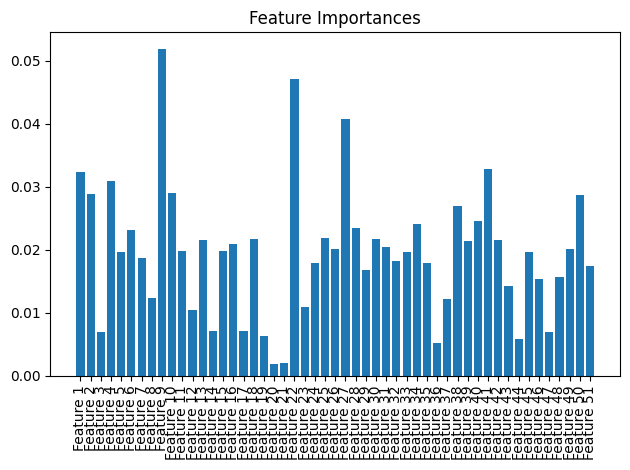

In [30]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["nv"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Feature Importances:
Feature 1: 0.026794969842319275
Feature 2: 0.033559077519648
Feature 3: 0.005683677020708849
Feature 4: 0.031533705702546946
Feature 5: 0.008781152059464864
Feature 6: 0.016782973474356346
Feature 7: 0.016994844576154904
Feature 8: 0.006993867412561087
Feature 9: 0.020859073757779855
Feature 10: 0.2135760306918606
Feature 11: 0.010663351717840828
Feature 12: 0.008357233658069797
Feature 13: 0.006563762699861074
Feature 14: 0.004341758259537801
Feature 15: 0.013951284526410767
Feature 16: 0.006544780088192608
Feature 17: 0.00609749895251031
Feature 18: 0.006414383418741414
Feature 19: 0.006436252139381262
Feature 20: 0.0016822423760102102
Feature 21: 0.0028362797706475954
Feature 22: 0.01697048394925334
Feature 23: 0.009131821392667518
Feature 24: 0.011170747245891482
Feature 25: 0.034239666384127676
Feature 26: 0.007500043572023949
Feature 27: 0.011063997626134518
Feature 28: 0.013322680971705324
Feature 29: 0.011468608183089018
Feature 30: 0.023146080793399852
Fea

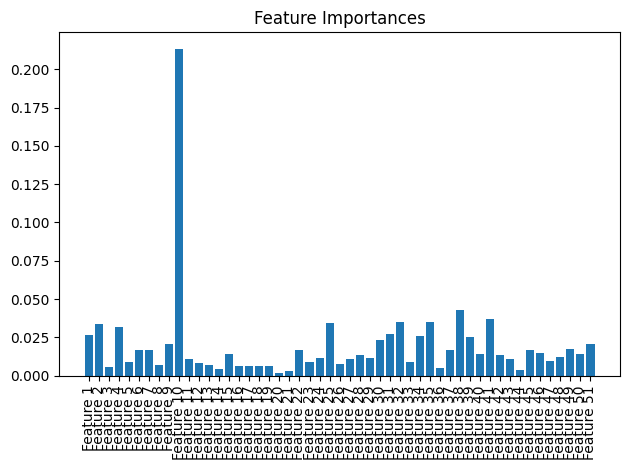

In [31]:
xtrain,xtest,ytrain,ytest=train_test_split(data.drop(columns=["akiec","bcc","bkl","df","mel","nv","vasc"]),data["vasc"],test_size=0.2,random_state=2)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
model1=RandomForestRegressor()
model1.fit(xtrain,ytrain)
feature_importances = model1.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(range(xtrain.shape[1]), feature_importances):
    print(f"Feature {feature + 1}: {importance}")

# Plotting feature importances
plt.bar(range(xtrain.shape[1]), feature_importances, tick_label=[f"Feature {i+1}" for i in range(xtrain.shape[1])])
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [32]:
import pickle
colsToRemove = ["WGHOMOGENEITY1","WGHOMOGENEITY2"]
for col in colsToRemove:
    if col in x:
        x.drop(col,axis=1,inplace=True)
# normalized_df.to_csv('features5000.csv', index=False)


scaler = StandardScaler()
normalized_features = scaler.fit_transform(x)
with open('scaler1.pkl','wb') as file:
    pickle.dump(scaler, file)
with open('scaler1.pkl','rb') as file:
    print(pickle.load(file))
# # Convert the normalized features back to a DataFrame
#normalized_df = pd.DataFrame(normalized_features, columns=x.columns)

StandardScaler()


In [9]:
# for i in finalRes.columns:
    # Visualize the distribution of each feature
    # finalRes[i].hist(bins=20, figsize=(15, 10))
    # plt.show()
# finalRes.hist(bins=20, figsize=(150, 100))
# x.hist(bins=20, figsize=(150, 100))
normalized_df.hist(bins=20, figsize=(150, 100))

array([[<Axes: title={'center': 'E'}>, <Axes: title={'center': 'SE'}>,
        <Axes: title={'center': 'TE'}>, <Axes: title={'center': 'NE'}>,
        <Axes: title={'center': 'GSM'}>,
        <Axes: title={'center': 'GSTD'}>,
        <Axes: title={'center': 'GL1N'}>],
       [<Axes: title={'center': 'GL2N'}>,
        <Axes: title={'center': 'GRAYP2P'}>,
        <Axes: title={'center': 'GSKEW'}>,
        <Axes: title={'center': 'GMEDIAN'}>,
        <Axes: title={'center': 'WGENERGY1'}>,
        <Axes: title={'center': 'WGENERGY2'}>,
        <Axes: title={'center': 'WGENERGY3'}>],
       [<Axes: title={'center': 'WGSTD1'}>,
        <Axes: title={'center': 'WGSTD2'}>,
        <Axes: title={'center': 'WGSTD3'}>,
        <Axes: title={'center': 'WGCONTRAST1'}>,
        <Axes: title={'center': 'WGCONTRAST2'}>,
        <Axes: title={'center': 'WGHOMOGENEITY1'}>,
        <Axes: title={'center': 'WGHOMOGENEITY2'}>],
       [<Axes: title={'center': 'GLCMenergy'}>,
        <Axes: title={'center':

In [24]:
print(normalized_df.columns)
# # removing features
colsToRemove = ["WGHOMOGENEITY1","WGHOMOGENEITY2"]
for col in colsToRemove:
    if col in normalized_df:
        normalized_df.drop(col,axis=1,inplace=True)
# normalized_df.to_csv('features5000.csv', index=False)
# normalized_df = pd.read_csv('features5000.csv')
print(normalized_df)

# # # Explore relationships between features
# # pd.plotting.scatter_matrix(finalRes, figsize=(150, 150))
# # pd.plotting.scatter_matrix(x, figsize=(150, 150))
# # plt.show()
# sns.pairplot(finalRes,hue="type")
# plt.show()

Index(['E', 'SE', 'TE', 'NE', 'GSM', 'GSTD', 'GL1N', 'GL2N', 'GRAYP2P',
       'GSKEW', 'GMEDIAN', 'WGENERGY1', 'WGENERGY2', 'WGENERGY3', 'WGSTD1',
       'WGSTD2', 'WGSTD3', 'WGCONTRAST1', 'WGCONTRAST2', 'WGHOMOGENEITY1',
       'WGHOMOGENEITY2', 'GLCMenergy', 'GLCMcontrast', 'GLCMentropy',
       'GLCMhomogeneity', 'LBP-1', 'LBP-2', 'LBP-3', 'LBP-4', 'LBP-5', 'LBP-6',
       'LBP-7', 'LBP-8', 'LBP-9', 'LBP-10', 'LBP-11', 'LBP-12', 'LBP-13',
       'LBP-14', 'LBP-15', 'LBP-16', 'LBP-17', 'LBP-18', 'LBP-19', 'LBP-20',
       'LBP-21', 'LBP-22', 'LBP-23', 'LBP-24', 'LBP-25', 'LBP-26'],
      dtype='object')
             E        SE        TE        NE       GSM      GSTD      GL1N  \
0    -1.353995 -1.353995 -0.226659 -1.353995  0.016304 -1.062430 -0.628331   
1    -0.085286 -0.085286 -0.001608 -0.085286  0.814054 -0.439191  0.641930   
2     0.194393  0.194393 -0.151642  0.194393  1.797138  0.307334  1.914983   
3     0.156750  0.156750 -0.226659  0.156750 -0.007528  0.552529 -0.055724

In [32]:
# ## Statistical Analysis
# # Calculate summary statistics for each feature
# feature_stats = normalized_df.describe()
# print(feature_stats)
feature_stats_normalized = normalized_df.describe()
print(feature_stats_normalized)

                 E            SE           TE            NE          GSM  \
count  3500.000000  3.500000e+03  3500.000000  3.500000e+03  3500.000000   
mean      5.700450  5.700450e+00     4.021429  3.159440e-01   160.578985   
std       0.843596  8.435959e-01    13.332186  4.675578e-02    16.131639   
min       0.000000 -3.203427e-16     0.000000 -1.775479e-17    71.483389   
25%       5.291137  5.291137e+00     1.000000  2.932580e-01   149.151393   
50%       5.863566  5.863566e+00     2.000000  3.249846e-01   160.933417   
75%       6.292465  6.292465e+00     4.000000  3.487560e-01   171.818569   
max       6.865837  6.865837e+00   128.000000  3.805348e-01   221.449533   

              GSTD           GL1N           GL2N      GRAYP2P        GSKEW  \
count  3500.000000    3500.000000    3500.000000  3500.000000  3500.000000   
mean     28.946799   82486.332000   84165.777273   169.150000    -1.356171   
std      10.522767    7526.295707    8188.092960    34.887269     0.859126   
min

In [33]:
# # Check for missing values
missing_values = finalRes.isnull().sum()
print(missing_values)

type               0
E                  0
SE                 0
TE                 0
NE                 0
GSM                0
GSTD               0
GL1N               0
GL2N               0
GRAYP2P            0
GSKEW              0
GMEDIAN            0
WGENERGY1          0
WGENERGY2          0
WGENERGY3          0
WGSTD1             0
WGSTD2             0
WGSTD3             0
WGCONTRAST1        0
WGCONTRAST2        0
WGHOMOGENEITY1     0
WGHOMOGENEITY2     0
GLCMenergy         0
GLCMcontrast       0
GLCMentropy        0
GLCMhomogeneity    0
LBP-1              0
LBP-2              0
LBP-3              0
LBP-4              0
LBP-5              0
LBP-6              0
LBP-7              0
LBP-8              0
LBP-9              0
LBP-10             0
LBP-11             0
LBP-12             0
LBP-13             0
LBP-14             0
LBP-15             0
LBP-16             0
LBP-17             0
LBP-18             0
LBP-19             0
LBP-20             0
LBP-21             0
LBP-22       

In [39]:
# ## Correlation Analysis
# # Compute the correlation matrix
# correlation_matrix = finalRes.corr()
correlation_matrix = normalized_df.corr()
print(correlation_matrix)

                        E        SE        TE        NE       GSM      GSTD  \
E                1.000000  1.000000  0.083470  1.000000 -0.181012  0.616651   
SE               1.000000  1.000000  0.083470  1.000000 -0.181012  0.616651   
TE               0.083470  0.083470  1.000000  0.083470 -0.066669  0.085571   
NE               1.000000  1.000000  0.083470  1.000000 -0.181012  0.616651   
GSM             -0.181012 -0.181012 -0.066669 -0.181012  1.000000 -0.168237   
GSTD             0.616651  0.616651  0.085571  0.616651 -0.168237  1.000000   
GL1N             0.079625  0.079625 -0.024109  0.079625  0.782061  0.381576   
GL2N            -0.142996 -0.142996 -0.061468 -0.142996  0.995926 -0.089071   
GRAYP2P          0.755778  0.755778  0.123490  0.755778 -0.011969  0.714110   
GSKEW           -0.364432 -0.364432 -0.022588 -0.364432 -0.368784  0.157885   
GMEDIAN         -0.008295 -0.008295 -0.049680 -0.008295  0.938743  0.113316   
WGENERGY1       -0.101982 -0.101982 -0.054918 -0.101

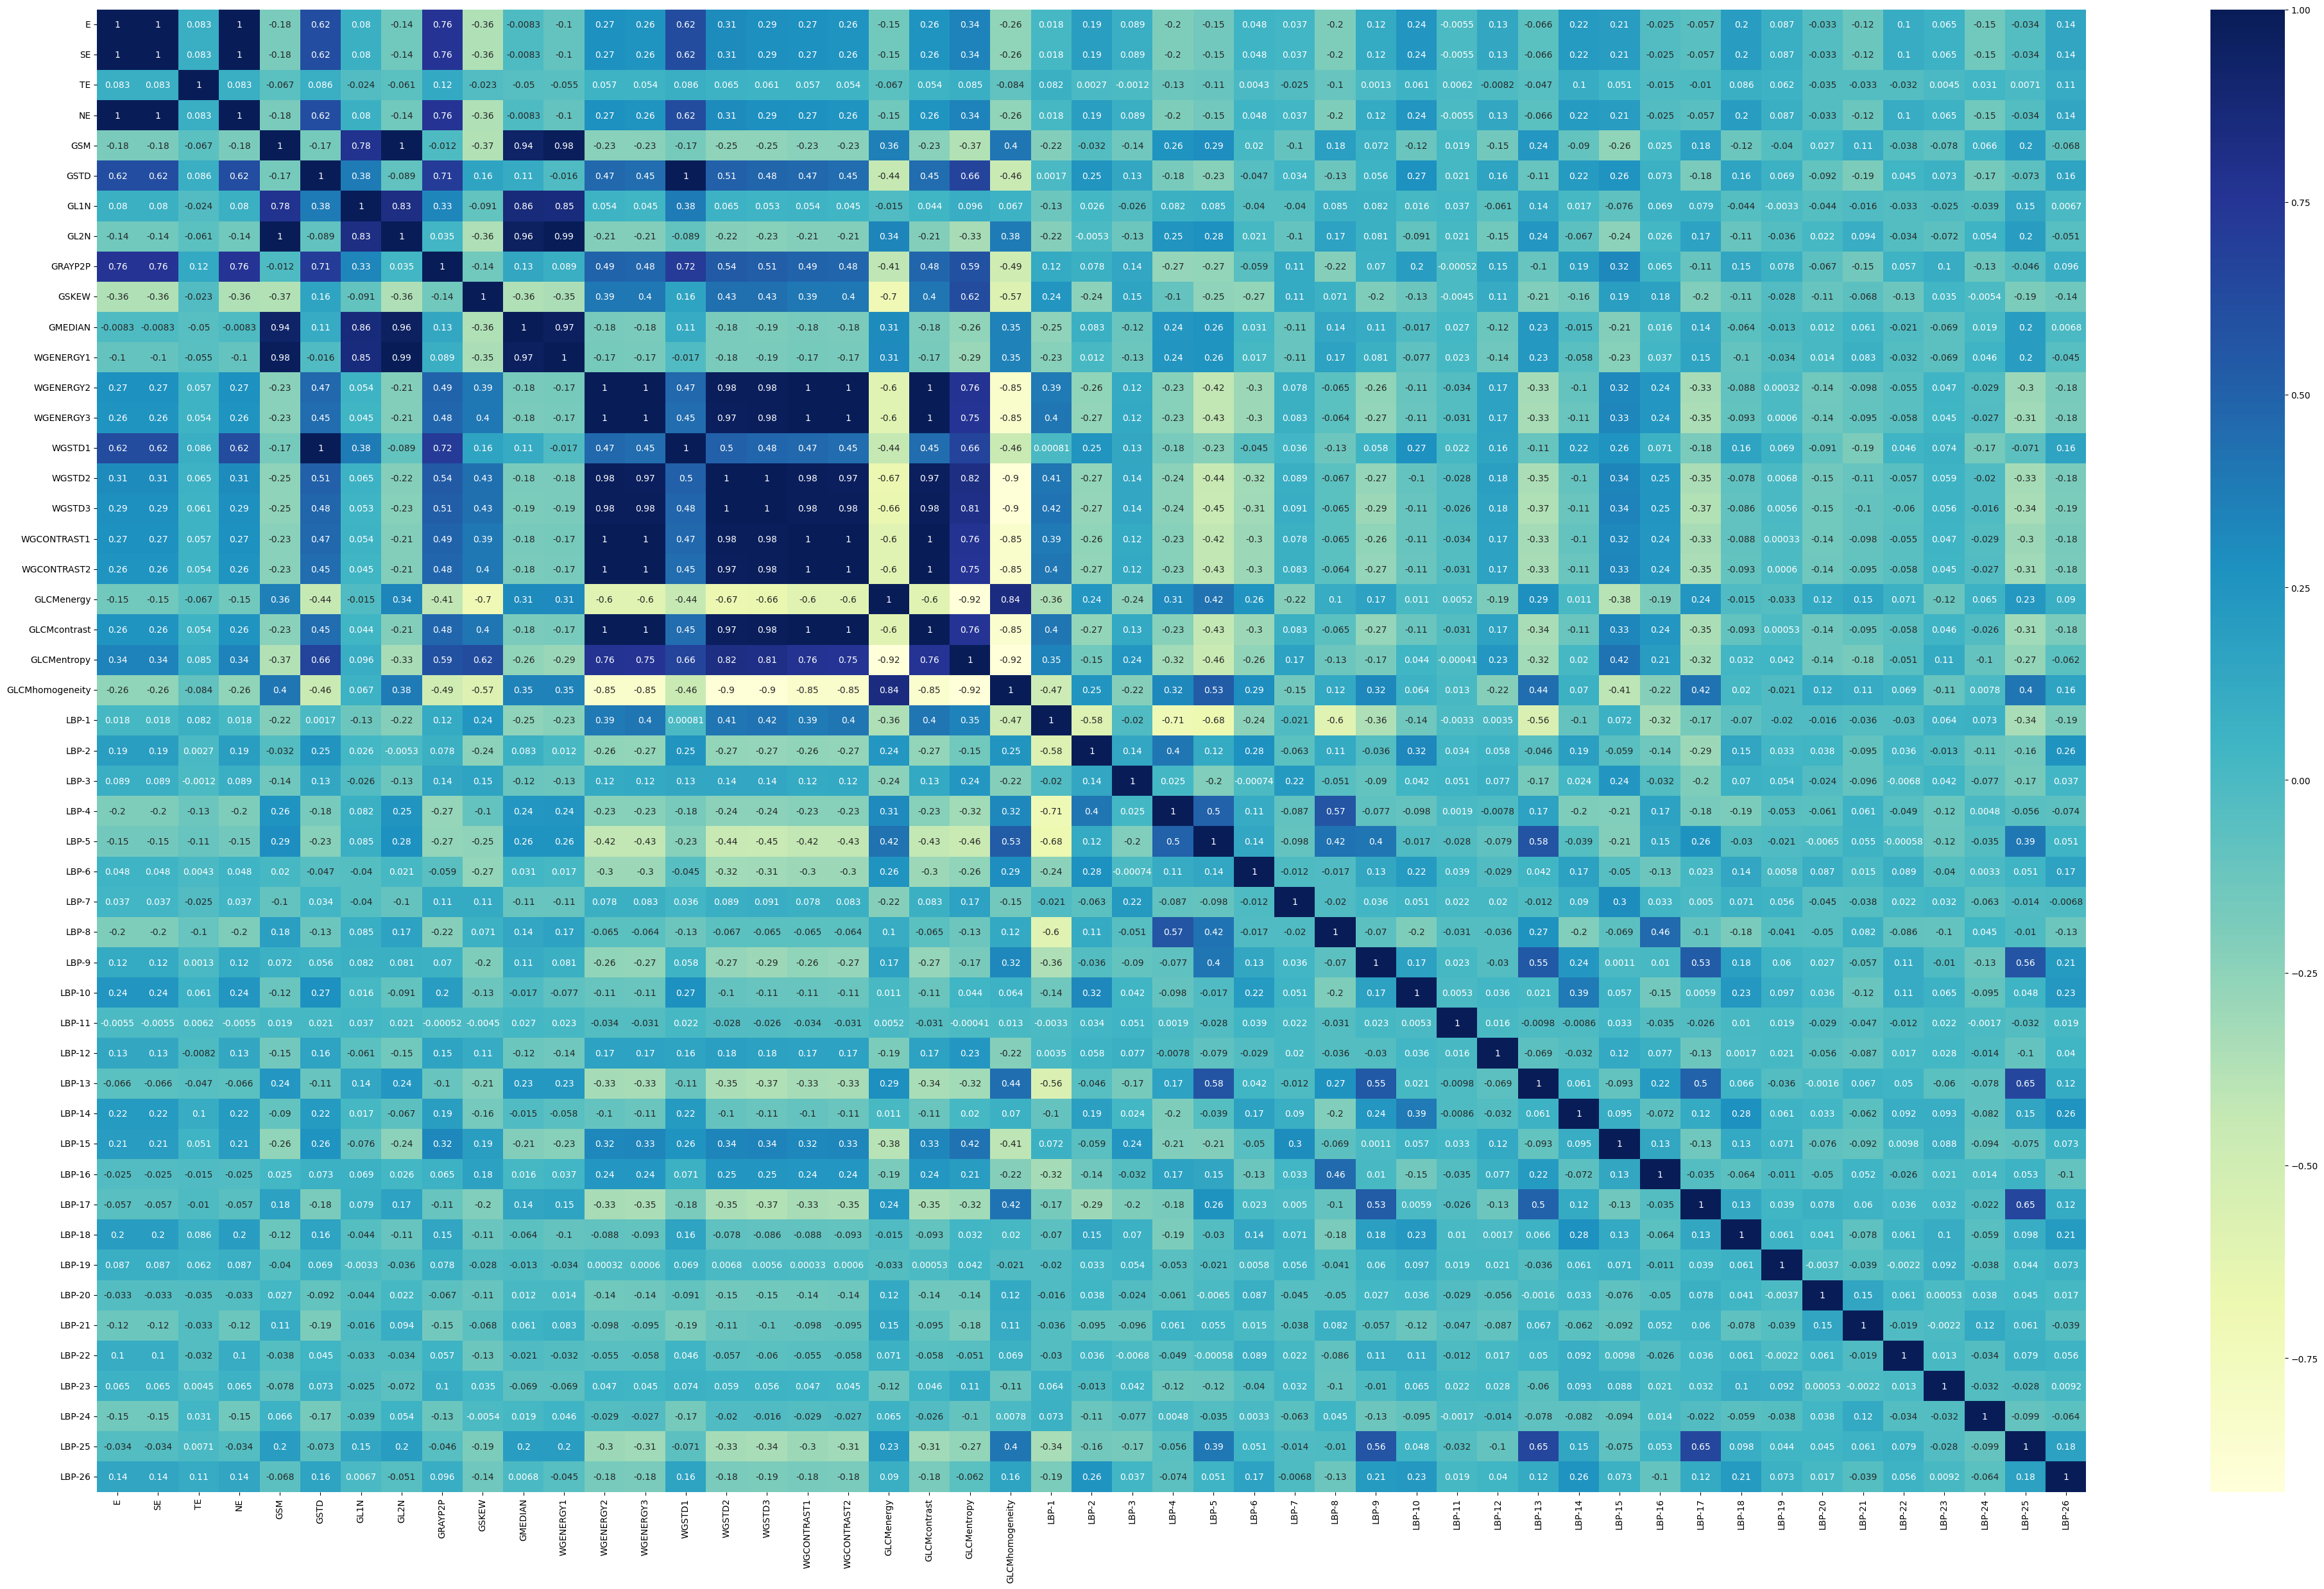

In [40]:
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.figure(figsize=(50, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.show()

In [25]:
## Train-Test Split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_df, y, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='rbf', C=7.5)  # You can adjust the kernel and other hyperparameters

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)
# print(np.array(y_test))
# print(y_pred_svm)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Display additional metrics
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.6828571428571428
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       126
           1       0.60      0.50      0.55       105
           2       0.44      0.38      0.41        95
           3       0.85      0.98      0.91       101
           4       0.48      0.54      0.51        87
           5       0.57      0.44      0.49        89
           6       0.90      1.00      0.95        97

    accuracy                           0.68       700
   macro avg       0.66      0.67      0.66       700
weighted avg       0.67      0.68      0.67       700



In [74]:
# ## Train-Test Split
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(normalized_df, y, test_size=0.2, random_state=42)

# svm_classifier = SVC(kernel='poly',degree=3)  # You can adjust the kernel and other hyperparameters

# # Train the SVM model
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_svm = svm_classifier.predict(X_test)
# # print(np.array(y_test))
# # print(y_pred_svm)

# # Evaluate the SVM model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# print("SVM Accuracy:", accuracy_svm)

# # Display additional metrics
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.5471428571428572
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       126
           1       0.41      0.48      0.44       105
           2       0.31      0.49      0.38        95
           3       0.79      0.77      0.78       101
           4       0.40      0.34      0.37        87
           5       0.45      0.43      0.44        89
           6       0.85      0.76      0.80        97

    accuracy                           0.55       700
   macro avg       0.57      0.54      0.55       700
weighted avg       0.59      0.55      0.56       700



In [79]:

import pickle

with open('skinCancer.pkl','wb') as file:
    pickle.dump(svm_classifier, file)
